In [1]:
library(tidyverse)

# Custom package
library(rutils)

-- Attaching packages -------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ----------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
dset_idx <- 1
# hub_con_thresh <- 0.25
hub_con_thresh <- 0.0

In [3]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
cancer_name <- c("cervical cancer", "none", "endometrial cancer")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [4]:
matrisome_df <- rutils::load_matrisome_df(matrisome_path) %>%
    dplyr::select(gene_symbol, division, category) %>%
    dplyr::rename(geneID = gene_symbol)
deseq_df <- read_tsv(paste0(dirs$analysis_dir, "/deg/", unified_dsets[dset_idx], "_DESeq_results.tsv")) %>%
    rename(base_mean = baseMean, lfc = log2FoldChange) %>%
    mutate(change_dir = ifelse(lfc > 0, "up", "down")) %>%
    select(geneID, change_dir, base_mean, lfc, qval)

demg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_demg_list.txt"))

figo_umsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_figo_umsmg_list.txt"))
figo_nsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_figo_nsmg_list.txt"))
figo_list <- figo_umsmg_list %>%
    union(figo_nsmg_list) %>%
    intersect(demg_list)

survival_umsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_survival_umsmg_list.txt"))
survival_list <- survival_umsmg_list %>%
    intersect(demg_list)


-- Column specification -------------------------------------------------------------------------------------
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)



-- Column specification -------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double(),
  qval = col_double()
)




In [5]:
pathology_df <- read_tsv(paste0(dirs$data_dir, "/THPA_v20_1_staining/pathology.tsv")) %>%
    rename_all(tolower) %>%
    rename_with(~ gsub(" - ", "_", .x, fixed = TRUE)) %>%
    rename_with(~ gsub(" ", "_", .x, fixed = TRUE)) %>%
    rename(geneID = gene_name) %>%
    select(geneID, cancer, high, medium, low, not_detected) %>%
    filter(cancer %in% cancer_name[dset_idx]) %>%
    filter(rowSums(is.na(.[,3:6])) == 0) %>%
    dplyr::mutate(
        detected_count = rowSums(.[c("high", "medium", "low")]),
        detected_prop = detected_count / (not_detected + detected_count),
        detected = detected_count > 0
    )


-- Column specification -------------------------------------------------------------------------------------
cols(
  Gene = col_character(),
  `Gene name` = col_character(),
  Cancer = col_character(),
  High = col_double(),
  Medium = col_double(),
  Low = col_double(),
  `Not detected` = col_double(),
  `prognostic - favorable` = col_double(),
  `unprognostic - favorable` = col_double(),
  `prognostic - unfavorable` = col_double(),
  `unprognostic - unfavorable` = col_double()
)




In [6]:
mat_path_df <- matrisome_df %>%
    inner_join(pathology_df, by = "geneID") %>%
    mutate(
        mat = TRUE,
        de = geneID %in% demg_list,
        figo_sig = geneID %in% figo_list,
        survival_sig = geneID %in% survival_list,
    ) %>%
    mutate(detected_f = factor(ifelse(detected, "detected_yes", "detected_no")))

nrow(mat_path_df)

mat_path_df %>%
    group_by(category) %>%
    summarize(pct_det = sum(detected) / n() * 100)

[1] 747

,category,pct_det
,<chr>,<dbl>
1,Collagens,65.62500
2,ECM Glycoproteins,68.66667
3,ECM Regulators,67.75956
4,ECM-affiliated Proteins,66.66667
5,Proteoglycans,55.17241
6,Secreted Factors,68.77828


In [7]:
mat_path_pivot_df <- mat_path_df %>%
    pivot_longer(cols = c("mat", "de", "figo_sig", "survival_sig"), names_to = "group", values_to = "group_val")
sig_mat_path_pivot_df <- mat_path_pivot_df %>%
    dplyr::filter(group_val == TRUE) %>%
    # All TRUE so don't need
    dplyr::select(-group_val) %>%
    dplyr::mutate(group_f = factor(group, levels = c("mat", "de", "figo_sig", "survival_sig")))

# Tests

In [8]:
oneway.test(detected_prop ~ group_f, data = sig_mat_path_pivot_df)


	One-way analysis of means (not assuming equal variances)

data:  detected_prop and group_f
F = 0.10555, num df = 3.000, denom df = 91.283, p-value = 0.9566


In [9]:
det_tab <- table(sig_mat_path_pivot_df$detected_f, sig_mat_path_pivot_df$group_f)
det_tab

              
               mat  de figo_sig survival_sig
  detected_no  243 144       53            5
  detected_yes 504 297      110           16

In [10]:
chisq.test(det_tab)


	Pearson's Chi-squared test

data:  det_tab
X-squared = 0.72607, df = 3, p-value = 0.8671


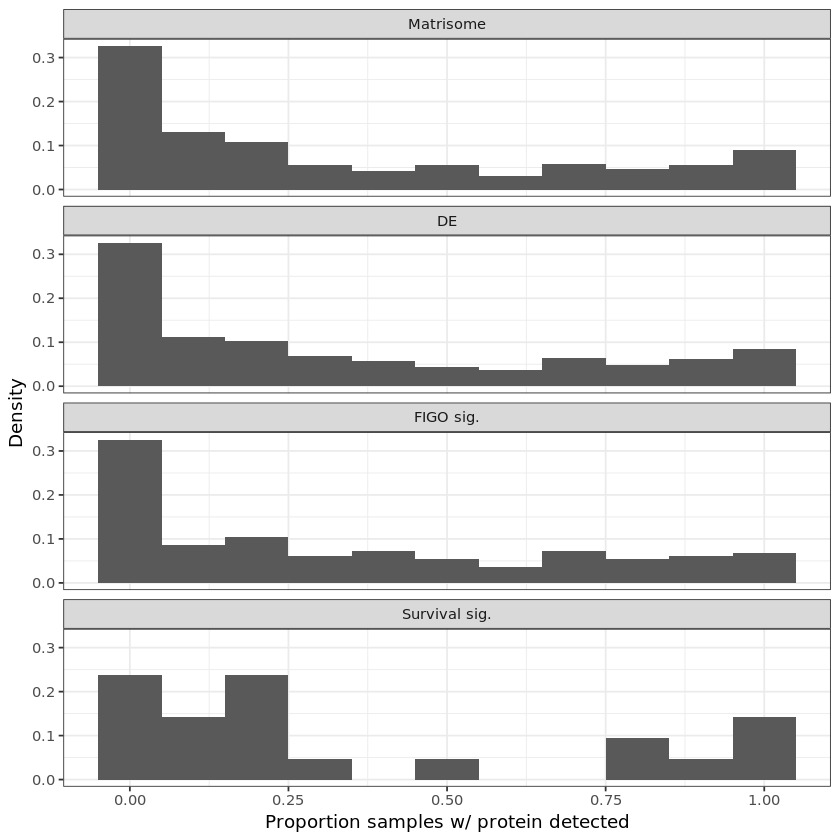

In [12]:
# ggplot(aes(x = detected_prop, y = stat(density)), data = sig_mat_path_pivot_df) +
bin_wid <- 0.1
# ggplot(aes(x = detected_prop, group = group_f), data = sig_mat_path_pivot_df) +
ggplot(aes(x = detected_prop), data = sig_mat_path_pivot_df) +
    geom_histogram(aes(y = ..density.. * bin_wid), position = , binwidth = bin_wid) +
    facet_wrap(~ group_f, nrow = 4, labeller = as_labeller(c("mat" = "Matrisome", "de" = "DE", "figo_sig" = "FIGO sig.", "survival_sig" = "Survival sig."))) +
    theme_bw() +
    labs(x = "Proportion samples w/ protein detected", y = "Density")